# 查看FashionMNIST原始数据格式

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(train_dataset[0])
train_dataset[0][0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1FC961AC200>, 9)


# 加载数据并处理为tensor

In [2]:
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))  
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称
class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")



训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [3]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


In [4]:
64*860

55040

# 搭建模型

In [5]:
#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


# 解析padding超参

In [6]:
# 初始化一个5*5的卷积层，保持输入输出图像尺寸不变
# 为了保持尺寸不变，需要设置适当的padding
# 对于kernel_size=5的卷积，需要padding=2才能保持尺寸不变

# 示例：创建一个单通道输入，16通道输出的卷积层
in_channels = 1
out_channels = 16
kernel_size = 5
padding = 2  # padding = (kernel_size - 1) / 2 可以保持尺寸不变

# 创建卷积层
# padding='same' 表示使用动态padding，保持输入输出图像尺寸不变,为same时，步长只能为1
# padding='valid' 表示不使用padding，输出图像尺寸会变小
conv = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2,stride=2)

# 创建一个示例输入(批次大小为4，单通道，28x28的图像)
x = torch.randn(4, 1, 28, 28)

# 前向传播
output = conv(x)

# 打印输入和输出的形状，验证尺寸是否保持不变
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"参数数量: {sum(p.numel() for p in conv.parameters())}")


输入形状: torch.Size([4, 1, 28, 28])
输出形状: torch.Size([4, 16, 14, 14])
参数数量: 416


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 第一组卷积层 - 32个卷积核
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 输入通道数，输出通道数代表的是卷积核的个数
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二组卷积层 - 64个卷积核
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        
        # 第三组卷积层 - 128个卷积核
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        
        # 计算全连接层的输入特征数
        # 经过3次池化，图像尺寸从28x28变为3x3x128
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化卷积层和全连接层的权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        
        # 第一组卷积层
        x = F.relu(self.conv1(x))
        # print(f"conv1后的形状: {x.shape}")
        x = F.relu(self.conv2(x))
        # print(f"conv2后的形状: {x.shape}")
        x = self.pool(x)
        # print(f"pool1后的形状: {x.shape}")
        
        # 第二组卷积层
        x = F.relu(self.conv3(x))
        # print(f"conv3后的形状: {x.shape}")
        x = F.relu(self.conv4(x))
        # print(f"conv4后的形状: {x.shape}")
        x = self.pool(x)
        # print(f"pool2后的形状: {x.shape}")
        
        # 第三组卷积层
        x = F.relu(self.conv5(x))
        # print(f"conv5后的形状: {x.shape}")
        x = F.relu(self.conv6(x))
        # print(f"conv6后的形状: {x.shape}")
        x = self.pool(x)
        # print(f"pool3后的形状: {x.shape}")
        
        # 展平
        x = x.view(x.size(0), -1)
        # print(f"展平后的形状: {x.shape}")
        
        # 全连接层
        x = F.relu(self.fc1(x))
        # print(f"fc1后的形状: {x.shape}")
        x = self.fc2(x)
        # print(f"fc2后的形状: {x.shape}")
        
        return x


In [8]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)
    

print(outputs.shape)


批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [9]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 584170
模型总参数量: 584170

各层参数量明细:
conv1.weight: 288 参数
conv1.bias: 32 参数
conv2.weight: 9216 参数
conv2.bias: 32 参数
conv3.weight: 18432 参数
conv3.bias: 64 参数
conv4.weight: 36864 参数
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 294912 参数
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


In [10]:
128*3*3*256

294912

# 各层参数量明细:
conv1.weight: 288 参数 3*3*1*32
conv1.bias: 32 参数
conv2.weight: 9216 参数 3*3*32*32
conv2.bias: 32 参数  
conv3.weight: 18432 参数 3*3*32*64
conv3.bias: 64 参数
conv4.weight: 36864 参数  3*3*64*64
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 294912 参数 128*3*3*256
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数

In [11]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.3112e-01,  8.8360e-02,  1.0894e-02],
                        [ 1.3015e-01,  9.7895e-02, -6.4727e-02],
                        [ 1.4007e-01,  6.8182e-02, -3.7146e-02]]],
              
              
                      [[[ 8.8410e-03, -1.2810e-01,  5.7973e-02],
                        [-9.4108e-02, -1.1393e-01, -4.8624e-02],
                        [-8.1526e-02,  1.0742e-02, -1.1196e-01]]],
              
              
                      [[[ 1.2845e-02, -1.7220e-02, -6.6677e-02],
                        [ 1.2713e-01,  5.0554e-02, -5.2511e-02],
                        [-1.2770e-01,  6.1094e-02, -1.2579e-01]]],
              
              
                      [[[-7.1261e-02,  7.3604e-02, -1.4084e-02],
                        [ 7.2881e-02, -7.1952e-03,  5.9737e-02],
                        [ 8.8655e-02, -5.2839e-02,  6.8862e-02]]],
              
              
                      [[[-1.2678e-01,  1.2722e-01, -9.7452e-02

# 设置交叉熵损失函数，SGD优化器

In [12]:
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)



损失函数: CrossEntropyLoss()


In [13]:
model = NeuralNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cpu
训练开始，共43000步


  0%|          | 0/43000 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 83.9200
早停: 在1800 步


In [15]:
history['train'][-100:-1]

[{'loss': 0.3886829912662506, 'acc': 81.25, 'step': 1701},
 {'loss': 0.41428837180137634, 'acc': 85.9375, 'step': 1702},
 {'loss': 0.30507606267929077, 'acc': 84.375, 'step': 1703},
 {'loss': 0.3232109844684601, 'acc': 92.1875, 'step': 1704},
 {'loss': 0.3435007631778717, 'acc': 89.0625, 'step': 1705},
 {'loss': 0.4838464558124542, 'acc': 82.8125, 'step': 1706},
 {'loss': 0.5474287271499634, 'acc': 79.6875, 'step': 1707},
 {'loss': 0.3897813558578491, 'acc': 87.5, 'step': 1708},
 {'loss': 0.46842217445373535, 'acc': 85.9375, 'step': 1709},
 {'loss': 0.372151255607605, 'acc': 82.8125, 'step': 1710},
 {'loss': 0.3453761637210846, 'acc': 87.5, 'step': 1711},
 {'loss': 0.4405008554458618, 'acc': 84.375, 'step': 1712},
 {'loss': 0.5823171734809875, 'acc': 79.6875, 'step': 1713},
 {'loss': 0.4685555398464203, 'acc': 81.25, 'step': 1714},
 {'loss': 0.4825715124607086, 'acc': 85.9375, 'step': 1715},
 {'loss': 0.4736955463886261, 'acc': 85.9375, 'step': 1716},
 {'loss': 0.6910049915313721, 'acc

In [16]:
history['val'][-1000:-1]

[{'loss': 2.3092327308654785, 'acc': 9.84, 'step': 0},
 {'loss': 2.2778964851379393, 'acc': 15.82, 'step': 50},
 {'loss': 2.1995261306762695, 'acc': 27.16, 'step': 100},
 {'loss': 1.5396133518218995, 'acc': 57.42, 'step': 150},
 {'loss': 1.0023589279174805, 'acc': 63.2, 'step': 200},
 {'loss': 0.9567477941513062, 'acc': 66.08, 'step': 250},
 {'loss': 0.942399394607544, 'acc': 66.92, 'step': 300},
 {'loss': 0.8909914328098297, 'acc': 67.64, 'step': 350},
 {'loss': 0.7802351087093353, 'acc': 71.52, 'step': 400},
 {'loss': 0.7335485120296479, 'acc': 73.84, 'step': 450},
 {'loss': 0.7016713613033295, 'acc': 74.4, 'step': 500},
 {'loss': 0.7071028431892395, 'acc': 74.58, 'step': 550},
 {'loss': 0.6791726182460784, 'acc': 75.7, 'step': 600},
 {'loss': 0.6310939739227295, 'acc': 77.48, 'step': 650},
 {'loss': 0.6323662961483002, 'acc': 77.62, 'step': 700},
 {'loss': 0.6904567311763763, 'acc': 74.94, 'step': 750},
 {'loss': 0.7012296488285065, 'acc': 75.68, 'step': 800},
 {'loss': 0.6246682698

# 绘制损失曲线和准确率曲线

In [17]:
# 导入绘图库
import matplotlib.pyplot as plt
from matplotlib import font_manager
def plot_learning_curves1(history):
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    # 创建一个图形，包含两个子图（损失和准确率）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    ax1.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    ax1.set_title('训练与验证损失')
    ax1.set_xlabel('轮次')
    ax1.set_ylabel('损失')
    ax1.legend()
    ax1.grid(True)

    # 绘制准确率曲线
    ax2.plot(epochs, history['train_acc'], 'b-', label='训练准确率')
    ax2.plot(epochs, history['val_acc'], 'r-', label='验证准确率')
    ax2.set_title('训练与验证准确率')
    ax2.set_xlabel('轮次')
    ax2.set_ylabel('准确率 (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


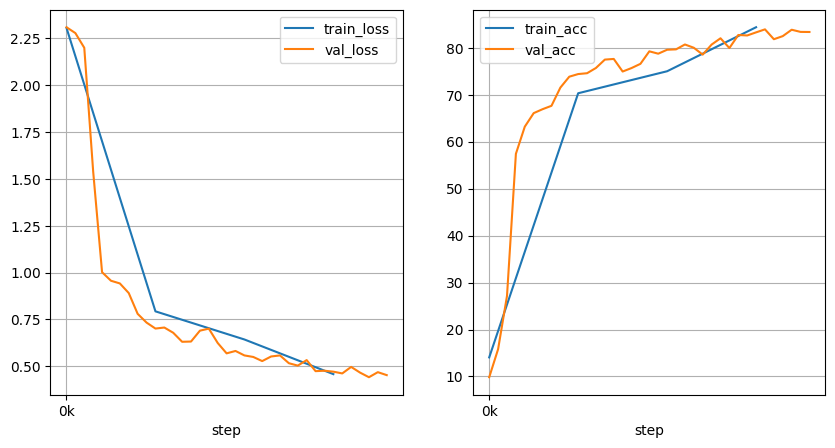

In [18]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [19]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(83.06, 0.4671364442586899)